# Intro to Weather Data in TileDB

## About this Example

This example shows using some standard geospatial Python tools (xarray, rasterio, cartopy, ...) with a group of TileDB arrays.

### What it Shows



### Set-up Requirements

This example requires the following Python libraries: tiledb, tiledb-cf, numpy, xarray, rasterio, cartopy, matplotlib, geopandas

In [5]:
import tiledb
import tiledb.cf

import geopandas as gpd
import numpy as np
import xarray as xr

import rasterio
import rasterio.features
import rasterio.transform

import cartopy.crs as ccrs
import matplotlib.pyplot as plt



In [6]:
import shutil

example_uri = "arrays/fake_weather_example"

# clean up any previous runs
try:
    shutil.rmtree(example_uri)
except:
    pass

## Create toy data

Create toy data (random array) and store over latitude, longitude, and date.

In [7]:
# Create toy data using tiledb.cf DataspaceCreator
creator = tiledb.cf.DataspaceCreator()
creator.add_shared_dim(dim_name="latitude", domain=(0, 179), dtype=np.uint32)
creator.add_shared_dim(dim_name="longitude", domain=(0, 359), dtype=np.uint32)
creator.add_shared_dim(dim_name="date", domain=(0, 30), dtype=np.uint32)
creator.add_array_creator(
    array_name="toy_data", dims=("date", "latitude", "longitude"), tiles=(31, 20, 20)
)
creator.add_attr_creator(
    attr_name="toy_data",
    array_name="toy_data",
    dtype=np.float64,
    fill=np.nan,
    filters=tiledb.FilterList([tiledb.ZstdFilter(7)]),
)
for data_name, data_dtype in zip(
    ("date", "latitude", "longitude"), (np.dtype("datetime64[D]"), np.float64, np.float64)
):
    creator.add_array_creator(array_name=f"{data_name}_axis_data", dims=(data_name,))
    creator.add_attr_creator(
        attr_name=f"{data_name}.data",
        array_name=f"{data_name}_axis_data",
        dtype=data_dtype,
        filters=tiledb.FilterList([tiledb.ZstdFilter(7)]),
    )
creator.create_group(example_uri)

In [8]:
with tiledb.cf.Group(example_uri, mode="w") as group:
    group.meta["description"] = "Small geospatial toy dataset for examples"
    with group.open_array(attr="toy_data") as data_array:
        data_array[:, :, :] = {"toy_data": np.random.rand(31, 180, 360)} # random data 
        toy_data_meta = tiledb.cf.AttrMetadata(data_array.meta, "toy_data")
        toy_data_meta["description"] = "randomly generated data"
    with group.open_array(attr="latitude.data") as latitude_array:
        latitude_array[:] = np.arange(-90, 90, 1, dtype=np.float64)
        latitude_meta = tiledb.cf.AttrMetadata(latitude_array.meta, "latitude.data")
        latitude_meta["units"] = "degrees north"
    with group.open_array(attr="longitude.data") as longitude_array:
        longitude_array[:] = np.arange(-180, 180, 1, dtype=np.float64)
        longitude_meta = tiledb.cf.AttrMetadata(longitude_array.meta, "longitude.data")
        longitude_meta["units"] = "degrees west"
    with group.open_array(attr="date.data") as date_array:
        date_array[:] = np.arange(
            np.datetime64("2021-01", "D"), np.datetime64("2021-02", "D"), np.timedelta64(1, "D")
        )
        date_meta = tiledb.cf.AttrMetadata(date_array.meta, "date.data")
        date_meta["description"] = "date (Gregorian calendar)"

### TileDB + xarray + Rasterio + Geopandas + Cartopy/Matplotlib

TileDB fits nicely in a standard geospatial workflow. Here we will show how to average data in Argentina over time and plot the results.

#### Notes on xarray

If `tiledb-cf` is in your Python environment, then you can use the TileDB backend for xarry to lazily load data into xarray.

* Currently only supports dense arrays.
* Datetime dimensions and dimensions with domain not starting at 0 are treated as coordinates.
* Group support is planned - in the meantime you can use `xarray.merge` to combine TileDB arrays.

In [9]:
dataset = xr.merge(
    xr.open_dataset(f"{example_uri}/{array_name}", engine="tiledb")
    for array_name in ["toy_data", "latitude_axis_data", "longitude_axis_data", "date_axis_data"]
)
dataset

<xarray.Dataset>
Dimensions:    (date: 31, latitude: 180, longitude: 360)
Coordinates:
  * latitude   (latitude) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * longitude  (longitude) float64 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * date       (date) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-01-31
Data variables:
    toy_data   (date, latitude, longitude) float64 ...

In [10]:
toy_data = dataset.toy_data
toy_data

<xarray.DataArray 'toy_data' (date: 31, latitude: 180, longitude: 360)>
[2008800 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * longitude  (longitude) float64 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * date       (date) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-01-31
Attributes:
    description:  randomly generated data

In [11]:
# 1. Get Argentina geometry data
boundaries = gpd.read_file("../data/boundaries.geojson")
argentina = boundaries.loc[boundaries["name"] == "Argentina"]
geom = argentina.geometry

# 2. Restrict xarray DataArray to the region of interest
bbox = rasterio.features.bounds(geom) # [left, bottom, right, top]
dx, dy = 0.0, 0.0
toy_data = toy_data.loc[:, bbox[1] - dx : bbox[3] + dx, bbox[0] - dx : bbox[2] + dx]


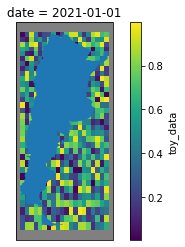

In [14]:
data_day1 = toy_data[0]
p = data_day1.plot(
    subplot_kws=dict(projection=ccrs.Mercator(), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)
p.axes.add_geometries(geom, crs=ccrs.PlateCarree(),)

In [ ]:

# 3. Mask data with geometry
width = len(toy_data.longitude)
height = len(toy_data.latitude)
mask = rasterio.features.geometry_mask(
    geom, 
    out_shape=(height, width),
    transform=rasterio.transform.from_bounds(
        toy_data.longitude[0], toy_data.latitude[-1], toy_data.longitude[-1], toy_data.latitude[0], width, height
    ),
    invert=True
)
mask_data_array = xr.DataArray(
    mask,
    dims=("latitude", "longitude"), 
    coords=[toy_data.latitude, toy_data.longitude]
)
masked_toy_data = toy_data.where(mask_data_array == True)

/home/julia/.pyenv/versions/3.9.1/envs/vscode-3.9.1/lib/python3.9/site-packages/xarray/plot/utils.py:444: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(**kwargs)


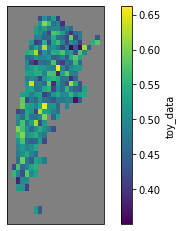

In [17]:
avg_data = masked_toy_data.mean(dim="date")
plot = avg_data.plot(
    subplot_kws=dict(projection=ccrs.Mercator(), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)